## Updates
- Pytesseract attempt (done 23/6/2023)
- [Perspective Transformation (perspective)](https://towardsdatascience.com/perspective-versus-affine-transformation-25033cef5766) (done 27/6/2023)
- update codebase for ocrimg and dashboard
- further generalize and automate the image preprocessing

- take note of python version, environment variables

In [1]:
import cv2
import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from imutils import resize, grab_contours
from sklearn.metrics import euclidean_distances
import regex as re
import json

In [2]:
# indicate the document height and width
doc_w, doc_h = 1098, 648

In [3]:
#helper code
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

def grayscale(src):
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    return gray

def median_blur(src):
    return cv2.medianBlur(src, 7)

def normalize(src):
    norm_img = np.zeros((src.shape[0], src.shape[1]))
    img = cv2.normalize(src, norm_img, 0, 255, cv2.NORM_MINMAX)
    return img

def contrast_enhance(src):
    return cv2.equalizeHist(src)

def remove_noise(src):
    return cv2.fastNlMeansDenoising(src, None, 10, 10, 7)

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def thresholding(src):
    return cv2.threshold(src, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) [1]

def non_max_suppression(src, D):
    '''makes edges dected in the canny image thinner'''
    M, N = src.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = src[i, j+1]
                    r = src[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = src[i+1, j-1]
                    r = src[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = src[i+1, j]
                    r = src[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = src[i-1, j-1]
                    r = src[i+1, j+1]

                if (src[i,j] >= q) and (src[i,j] >= r):
                    Z[i,j] = src[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

def adaptative_threshold(src):
    '''obtain binary thresholded image of blurred image'''
    mask = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 10)
    return mask

def bimodal_threshold(src):
    _, thres = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return thres

def hysteresis(src, weak, strong=255):
    '''contrast between weak and strong pixels is increased'''
    M, N = src.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (src[i,j] == weak):
                try:
                    if ((src[i+1, j-1] == strong) or (src[i+1, j] == strong) or (src[i+1, j+1] == strong)
                        or (src[i, j-1] == strong) or (src[i, j+1] == strong)
                        or (src[i-1, j-1] == strong) or (src[i-1, j] == strong) or (src[i-1, j+1] == strong)):
                        src[i, j] = strong
                    else:
                        src[i, j] = 0
                except IndexError as e:
                    pass
    return src

def get_edges(src, threshold = 50):
    '''input an image opened by invoking cv2.imread.
        output the same image reduced to its edges.'''
    # convert the image to grayscale, blur it, and find edges
    aspect_ratio = src.shape[1] / src.shape[0]
    threshold_height = int(threshold / aspect_ratio)
    return cv2.Canny(src, threshold, threshold_height, apertureSize=3)

def morph(src):
    return cv2.morphologyEx(src, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)))

def equalize(src):
    # converting to LAB color space
    lab= cv2.cvtColor(src, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    result = np.hstack((src, enhanced_img))
    return result

def remove_glare(img: np.ndarray, brightness: int):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_lab[:, :, 0] = brightness
    return cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

In [4]:
def get_all_boxes(edged):
	cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	cnts = grab_contours(cnts)
	cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
	# loop over the contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
		# if our approximated contour has four points, then we
		# can assume that we have found our screen
		if len(approx) >= 4:
			screenCnt = approx
			break

	return screenCnt

def select_coords(screenCnt):
    screenCnt = screenCnt.reshape(len(screenCnt), 2)

    #sorted_points = np.array(sorted(screenCnt, key=lambda x: x[0]))
    left, right, top, bottom = min(screenCnt[:, 0]), max(screenCnt[:, 0]), min(screenCnt[:, 1]), max(screenCnt[:, 1])

    topleft = min(screenCnt, key=lambda x: euclidean_distances([x], [(left, top)]))
    topright = min(screenCnt, key=lambda x: euclidean_distances([x], [(right, top)]))
    bottomleft = min(screenCnt, key=lambda x: euclidean_distances([x], [(left, bottom)]))
    bottomright = min(screenCnt, key=lambda x: euclidean_distances([x], [(right, bottom)]))
    
    return topleft, topright, bottomleft, bottomright

In [5]:
def crop_image(img, topleft, topright, bottomleft, bottomright):
    max_h, max_w = img.shape[:2]

    #initialize points: input convert to top-down output
    input_pts = np.float32([list(coord) for coord in [topleft, bottomleft, bottomright, topright]])
    output_pts = np.float32([[0, 0],
                            [0, max_h - 1],
                            [max_w - 1, max_h - 1],
                            [max_w - 1, 0]])
    
    # Compute the perspective transform mat
    transform_mat = cv2.getPerspectiveTransform(input_pts, output_pts)
    out = cv2.warpPerspective(img, transform_mat, (max_w, max_h), flags=cv2.INTER_LINEAR)
    return out

In [6]:
def extract_text(img, lang):
    return pytesseract.image_to_string(img, lang = lang)

def extract_name(ocr_result):
    # Define pattern to extract company
    company_pattern = r'(?i)(?:^|\b)([A-Z][A-Za-z]+(?: [A-Z][A-Za-z]+)*)(?:\b|$)'

    # Extract company using regular expression pattern
    company_match = re.search(company_pattern, ocr_result)
    if company_match:
        return company_match.group(1)
    else:
        return None

def extract_email(text):
    pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.,-]+\.[A-Z|a-z]{2,}(?:,[A-Za-z]+(?:\.[A-Za-z]+)?)*\b"
    emails = re.findall(pattern, text)
    if emails:
        return " - ".join(emails)
    return ""

def extract_company(ocr_text):
    patterns = [
        r"(?i)(Pte Ltd|PTE LTD|\(Pte.\) Ltd\.|Co, Ltd|Co\., Ltd|CO\. PTE LTD|Ltd|Ltd\.) Trading",
        r"(?i)(Pte Ltd|PTE LTD|\(Pte.\) Ltd\.|Co, Ltd|Co\., Ltd|CO\. PTE LTD|Ltd|Ltd\.)",
        r"[\w\s]+"
    ]

    company_names = []

    for pattern in patterns:
        matches = re.findall(pattern, ocr_text)
        for match in matches:
            stripped_match = match.strip()
            if not any(char.isdigit() for char in stripped_match) and stripped_match != "":
                ignore_keywords = ["com", "www", "website"]
                if not any(keyword.lower() in stripped_match.lower() for keyword in ignore_keywords):
                    company_names.append(stripped_match)

    return " - ".join(company_names)

def extract_contact(ocr_result):
    # Extract contact number using regular expression pattern
    patterns = [
        r"\d{8}",  # 00000000
        r"\d{4} \d{4}",  # 0000 0000
        r"\d{2} \d{4} \d{4}",  # 65 0000 0000
        r"\(\d{2}\) \d{4} \d{4}",  # (65) 0000 0000
        r"\+\d{2} \d{4} \d{4}",  # +65 0000 0000
        r"\+\d{2} \d{4}-\d{4}",  # +65 0000-0000
        r"\+\d{2} \d{8}",  # +65 00000000
        r"\+\(\d{2}\) \d{4} \d{4}",  # +(65) 0000 0000
        r"\+\(\d{3}\) \d{3} \d{3} \d{3}",  # +(000) 000 000 000
        r"\+\d{2}-\d{2}-\d{4}-\d{4}",  # +00-00-0000-0000
        r"\+\d{2}-\d{3}-\d{2}-\d{4}",  # +00-000-00-0000
        r"\+\d{2} \d-\d{4}-\d{4}"  # +00 0-0000-0000
    ]

    contact_numbers = []

    for pattern in patterns:
        matches = re.findall(pattern, ocr_result)
        if matches:
            contact_numbers.extend(matches)

    return " - ".join(contact_numbers)
    

# function to produce the json
def extract_json(img, lang):
    res_dict = {}
    
    extracted_txt = extract_text(img, lang = lang)
    res_dict["name"], res_dict["email"], res_dict["contact"], res_dict["company"] = extract_name(extracted_txt), extract_email(extracted_txt), extract_contact(extracted_txt), extract_company(extracted_txt)
    
    res_json = json.dumps(res_dict)
    return res_json


## Driver code

This is the test case. We will be conducting the following:

- Evaluate the accuracy of the edge detection performed, in this case we have only tried Canny Edge Detection without any Thresholding
- Show the final output of performing OCR on the card.

The best model will be transferred to the deployment phase.

'{"name": "KONICA MINOLTA", "email": "tai@konicaminolta.com", "contact": "65635533 - 6561 9879 - 9761 0376", "company": "PTE LTD - KONICA MINOLTA\\n\\nGiving Shape to Idea\\n\\nClarence Tai - clarence - tai - konicaminolta - wew - konicaminolta asia - business"}'

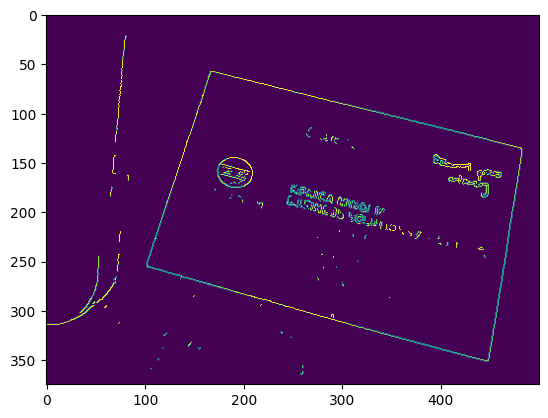

In [9]:
test_path = "./Images/20230704_151618.jpg"
img = cv2.imread(test_path)

# resize an image for better precision
img_resize = resize(img, width=500)
even = remove_glare(img_resize, 100)
edged = get_edges(even)
plt.imshow(edged)

topleft, topright, bottomleft, bottomright = select_coords(get_all_boxes(edged))
transformed = crop_image(img_resize, topleft, topright, bottomleft, bottomright)
#equal = equalize(transformed)

cv2.imshow("transformed", transformed)
#cv2.imshow("equalized", equal)
cv2.waitKey(0)
extract_json(transformed, lang = 'eng')

In [ ]:
# #test the accuracy of the bounding boxes
# from pytesseract import Output

# #new_img = transform_image(cv2.resize(img, dsize = (doc_w, doc_h), interpolation=cv2.INTER_LINEAR))
# new_img = transform_image(imutils.resize(img, height = 500))

# #pytesseract.image_to_string(new_img)
# h, w, c = new_img.shape
# words = pytesseract.image_to_data(new_img, output_type=Output.DICT) 

# n_boxes = len(words['level'])
# for i in range(n_boxes):
#     (x, y, w, h) = (words['left'][i], words['top'][i], words['width'][i], words['height'][i])
#     cv2.rectangle(new_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# # testing the json function
# #extract_json(test_path, "eng")

# cv2.imshow("Test case", new_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

NameError: name 'imutils' is not defined